
## Install detectron2

>Important: If you're running on a local machine, be sure to follow the installation instructions. This notebook includes only what's necessary to run in Colab.



In [1]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
!pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
torch.__version__
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 723.9 MB 18 kB/s s eta 0:00:01    |███                             | 68.8 MB 60.6 MB/s eta 0:00:11     |███▌                            | 79.0 MB 60.6 MB/s eta 0:00:11 MB 30.6 MB/s eta 0:00:21     |████▍                           | 99.6 MB 30.6 MB/s eta 0:00:21     |█████████                       | 201.7 MB 58.8 MB/s eta 0:00:09     |███████████████▌                | 350.4 MB 54.6 MB/s eta 0:00:07 | 591.5 MB 252 kB/s eta 0:08:45
     |████████████████████████████████| 4.0 MB 10.0 MB/s eta 0:00:01     |█                               | 112 kB 10.0 MB/s eta 0:00:01
  Attempting uninstall: torch
    Found existing installation: torch 1.5.1
    Uninstalling torch-1.5.1:
      Successfully uninstalled torch-1.5.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.6.0a0+35d732a
    Uninstalling torchvision-0.6.0a0+35d732a:
      Successfully uninstalle

In [2]:
# install detectron2:
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html
     |████████████████████████████████| 6.7 MB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 1.1 MB/s eta 0:00:01
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=273757 sha256=c02d68a9d58dd26531488c37193b4efcaf91d7fe175b553e805ad1816fc33ec8
  Stored in directory: /root/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
  Created wheel for fvcore: filename=fvcore-0.1.5.post20210330-py3-none-any.whl size=58836 sha256=6ab8bf252802615042022505775de6bb7557e52a40da0db2919337275c398791
  Stored in directory: /root/.cache/pip/wheels/43/e1/e1/c2c64a3945d94e9c3659a53c9b3756b9b886c2b8113f2852a5
Successfully built pycocotools fvcore
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0
    Uninstalling pycocotools-2.0:
      Successfully uninstalled pycocotools-2.0
You should consider upgradin

## Imports

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities


import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the [official documentation](https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset).


In [4]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2
import xml.etree.ElementTree as ET

def get_mask_dicts(data_dir):
    classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']
    annotation_files = os.listdir(os.path.join(data_dir,'annotations'))
    
    dataset_dicts = []
    for filename in annotation_files:
        record = {}
        root = ET.parse(os.path.join(data_dir, 'annotations', filename)).getroot()
                
        record["file_name"] = os.path.join(data_dir, 'images', root.find('filename').text)
        record["height"] = int(root.find('size/height').text)
        record["width"] = int(root.find('size/width').text)
        
        objs = []
        
        for member in root.findall('object'):
            obj = {
                'bbox': [int(member[5][0].text), int(member[5][1].text), int(member[5][2].text), int(member[5][3].text)],
                'bbox_mode': BoxMode.XYXY_ABS,
                'category_id': classes.index(member[0].text),
                'iscrowd': 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['with_mask', 'without_mask', 'mask_weared_incorrect']

DatasetCatalog.register('mask_dataset', lambda: get_mask_dicts('../input/face-mask-detection'))
MetadataCatalog.get('mask_dataset').set(thing_classes=classes)
chess_metadata = MetadataCatalog.get('mask_dataset')

In [6]:
# import random
# from detectron2.utils.visualizer import Visualizer

# dataset_dicts = DatasetCatalog.get('mask_dataset')
# for d in random.sample(dataset_dicts, 10):
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=chess_metadata)
#     vis = visualizer.draw_dataset_dict(d)
#     plt.figure(figsize = (14, 10))
#     plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
#     plt.show()

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.


In [28]:
# from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3

In [29]:
cfg.MODEL.WEIGHTS = os.path.join("../input/detectron2-mask-detect/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
cfg.DATASETS.TEST = ("mask_dataset", )
predictor = DefaultPredictor(cfg)

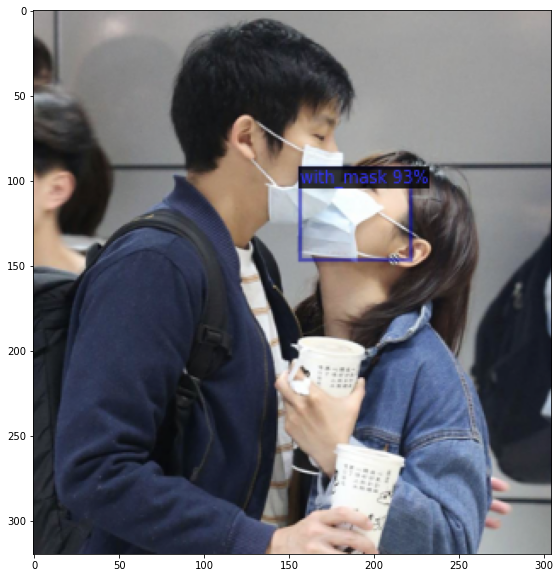

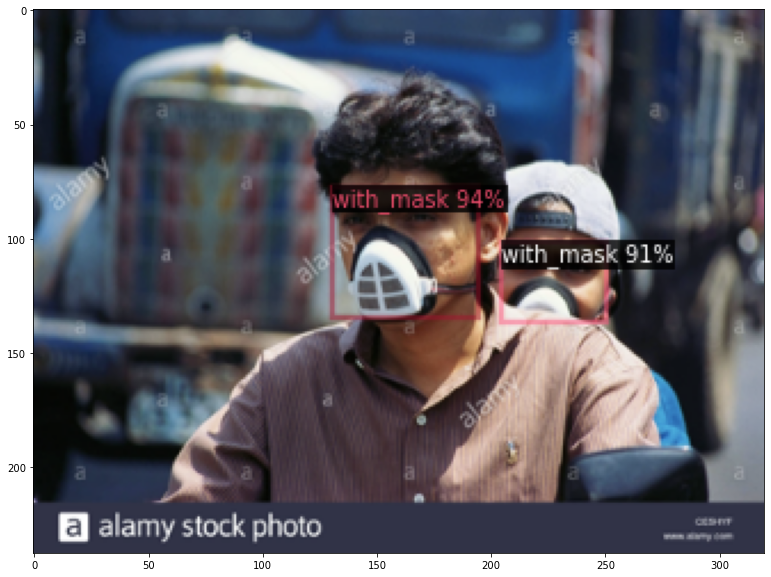

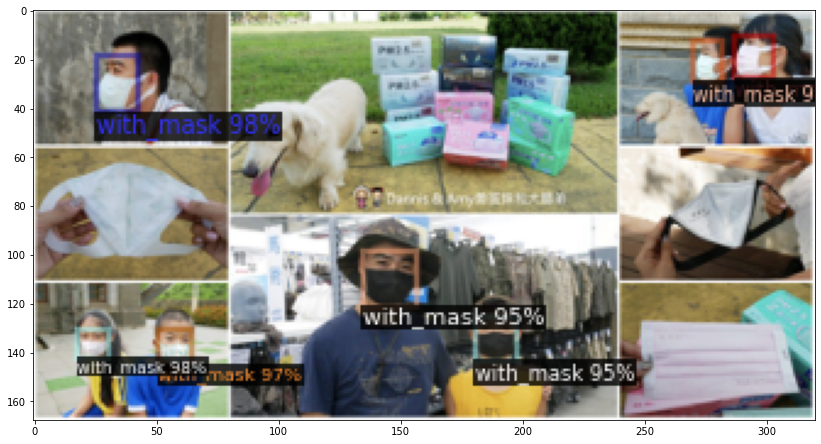

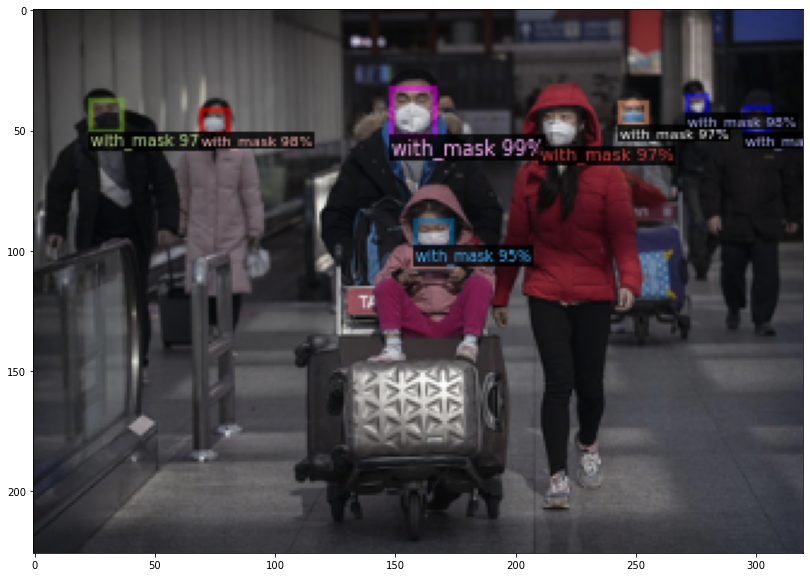

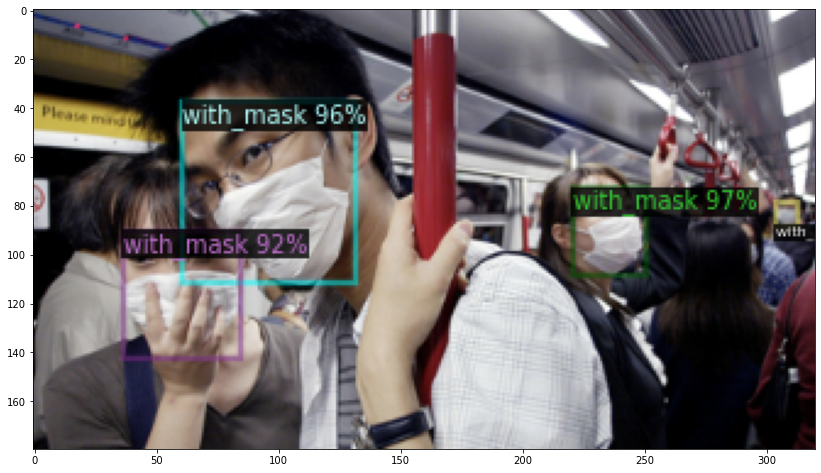

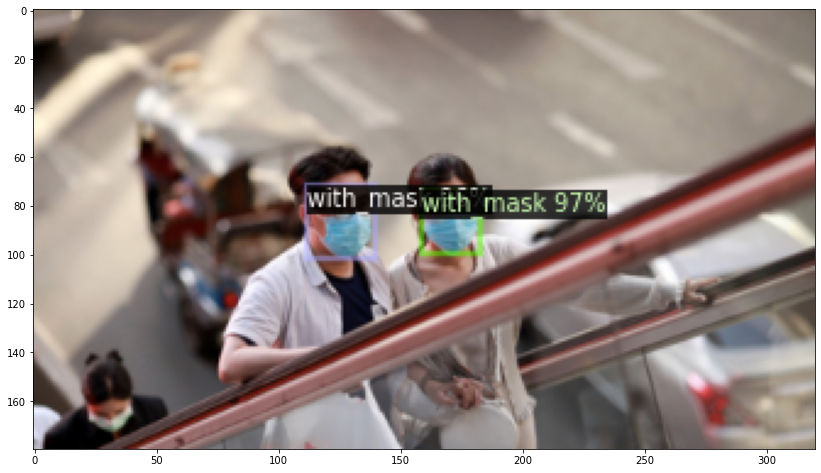

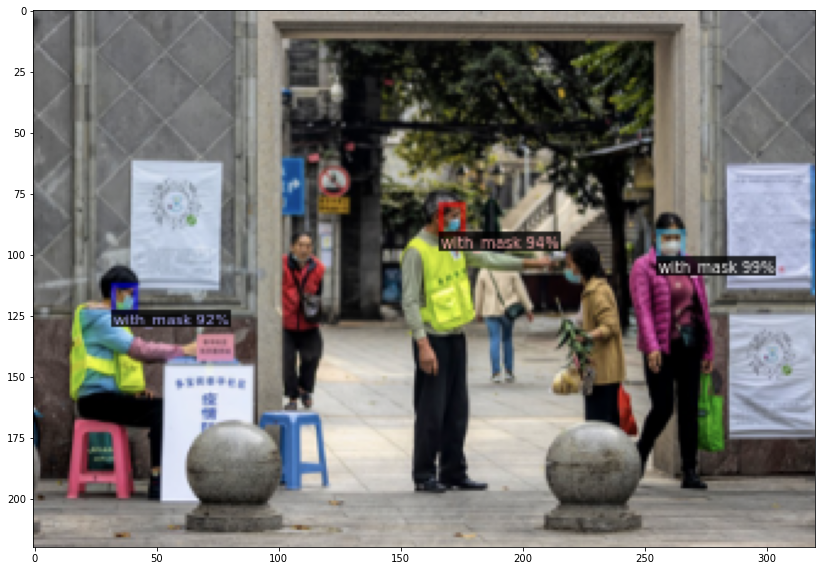

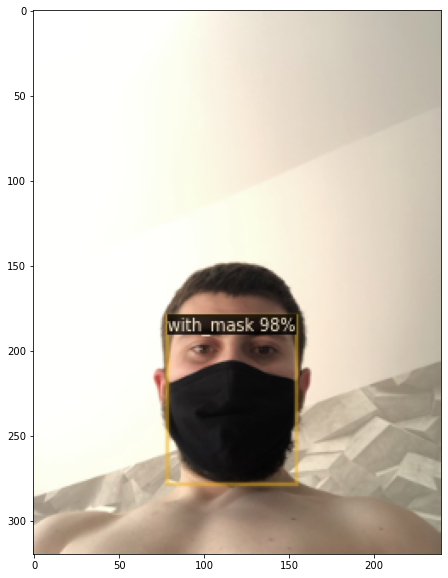

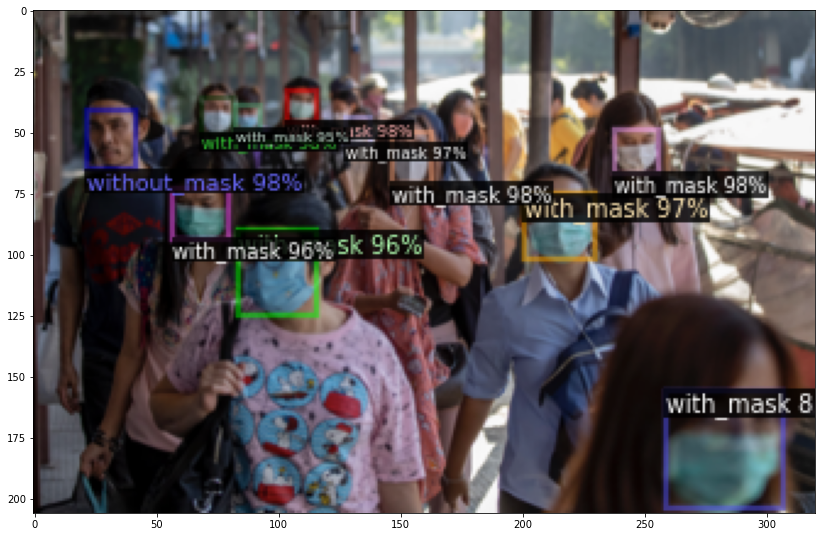

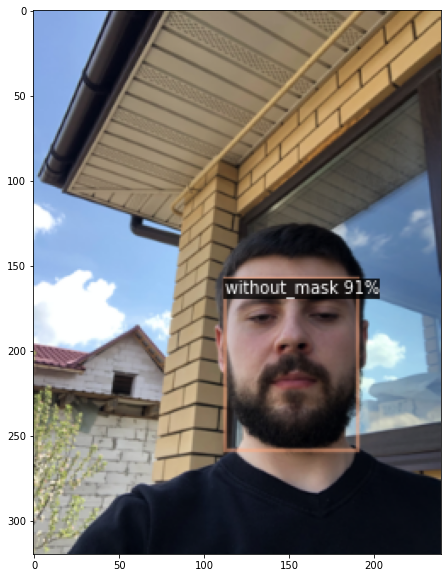

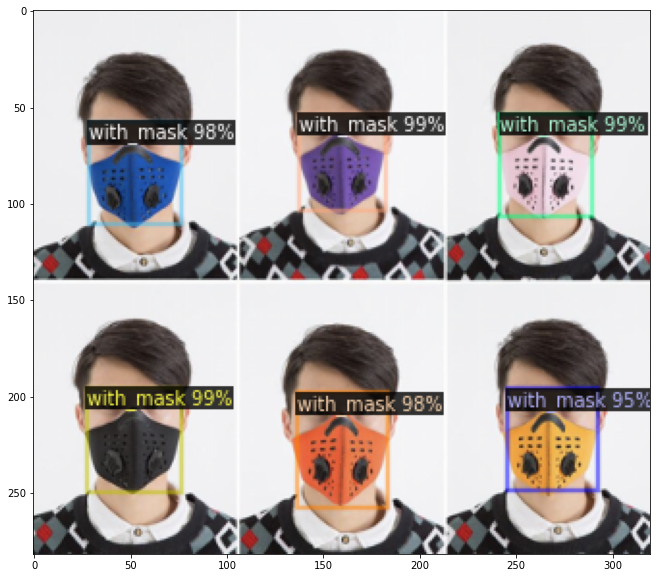

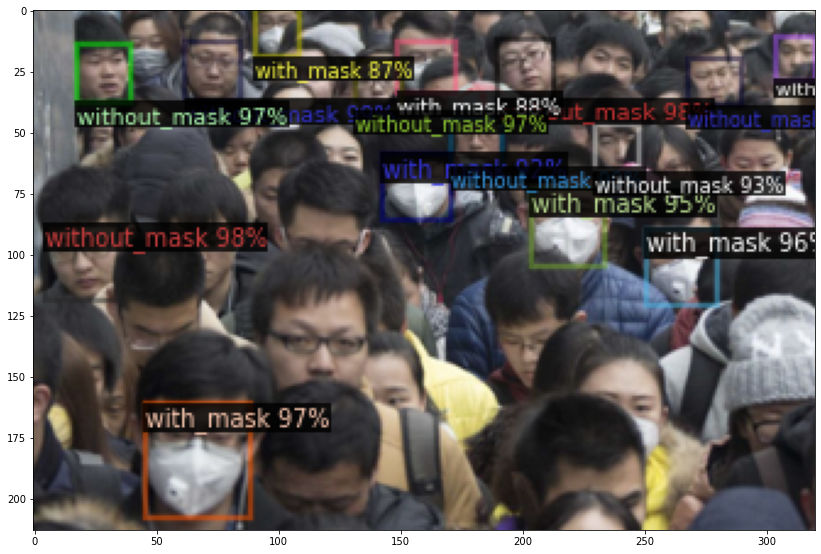

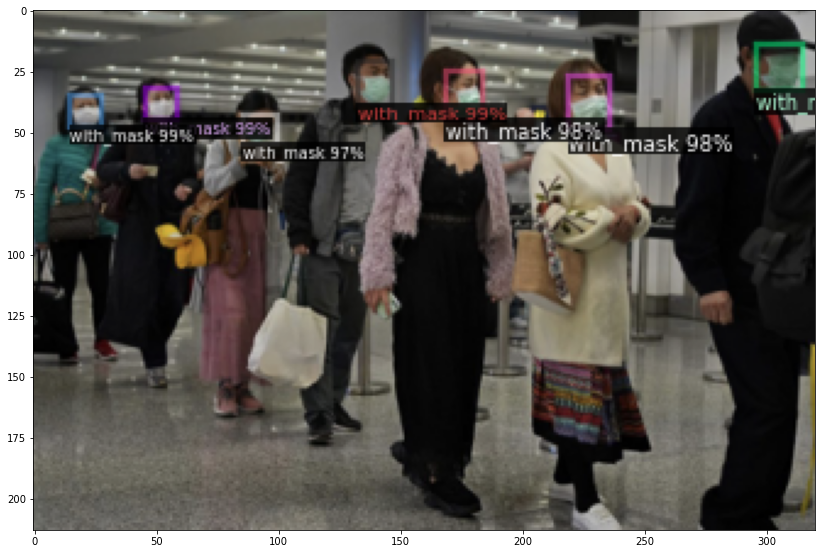

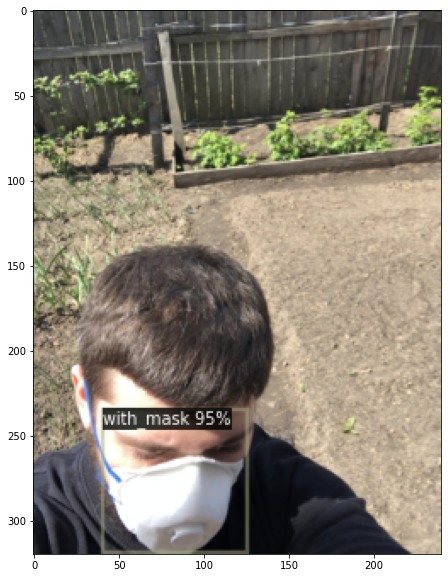

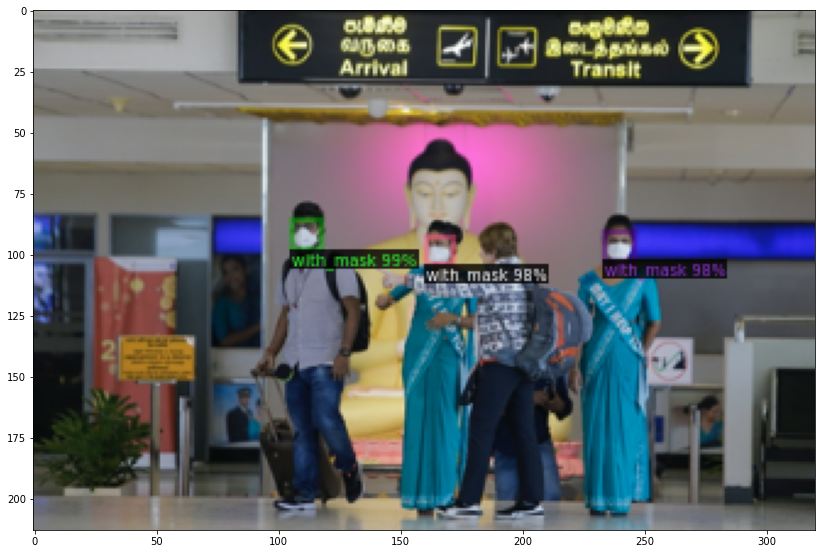

In [30]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = DatasetCatalog.get('mask_dataset')
for d in random.sample(dataset_dicts, 15):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=chess_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()